In [1]:
%matplotlib inline
import numpy as np
import sklearn as skl
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC, LinearSVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.dummy import DummyClassifier
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler, OneSidedSelection
from imblearn.over_sampling import SMOTE
sns.set_style('darkgrid')


資料預處理

In [2]:
from sklearn.preprocessing import OneHotEncoder as OHE
from sklearn.preprocessing import LabelEncoder as LE
train_path = './TraData.csv'
data = pd.read_csv(train_path, sep=',') #.sample(100000) # toy
label = data.click
del data['click'] # 記得別讓答案變成一組 feature ，這樣 model 就直接看到答案了
# 特徵選擇、降維 改交給 SVD 分解完成
del data['ip']
del data['spaceCat']
# del data['adType']
# del data['os']
del data['deviceType']
del data['publisherId']
del data['dclkVerticals']
# del data['campaignId']
# del data['advertiserId']
le_list = {}
for key, value in data.iteritems():
    le_list[key] = LE() ## 字串特徵轉屬性資料（類別）
    data[key] = le_list[key].fit_transform(value) ## csv 檔中 feature 均為屬性資料

ohe = OHE() # 屬性資料是離散資料，進入 SVM, MLP 等模型之前必須轉獨熱編碼
data = ohe.fit_transform(data).todense()
# print data[:3] ## 印出隨機三筆資料觀察

# pos_num = np.sum(label==1)
# neg_num = len(label)-pos_num
# pos_r = pos_num / float(len(label))
# neg_r = neg_num / float(len(label))
# print pos_r, neg_r # 印出類別權重
# class_weight = {0:pos_r, 1:neg_r} # 將類別出現次數乘上權重


In [3]:
from sklearn.model_selection import train_test_split
data, X_test, label, Y_test = train_test_split(data, np.asarray(label).flatten(), test_size=0.1)
print data.shape
print X_test.shape
print label.shape
print Y_test.shape

(865311, 404)
(96146, 404)
(865311,)
(96146,)


設定模型參數、建構模型

In [4]:
class_weight={0:1,1:16}
## DT on sklearn is based on CART algorithm. Let's try ID3&CART algorithm both. And SVM.
classifiers = {
               # 'SVC':SVC(verbose=1, kernel='rbf'), 
               #'LinearSVC':LinearSVC(),
                'DecisionTree': tree.DecisionTreeClassifier(max_depth=5, class_weight=class_weight),
                'KNN_dist': KNN(n_neighbors=3, weights='distance',),
                'KNN_uni': KNN(n_neighbors=3, weights='uniform',),
               # SVM 複雜度太高了，算不完 O(n^3~n^4), 使用簡單的 LinearSVM(O(N))]
               # 'Random':DummyClassifier('uniform'), ## 下面這兩個是 baseline ，不應該比亂猜/都猜0還差
               # 'Guess0':DummyClassifier('most_frequent')
              }

In [5]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
svd = PCA(n_components=30) # 降維，維度太高會發生'維度災難'
data = svd.fit_transform(data)
print data.shape
print 'info: %.2f'%np.sum(svd.explained_variance_ratio_)
print 'nans: %d'%np.sum(np.isnan(data))

(865311, 30)
info: 0.88
nans: 0


3-fold Cross-validation

In [6]:
kfold = StratifiedKFold(n_splits=5, shuffle=True)
models = []
cvscores = []
for model_name, model in classifiers.items():
    print('Training %s...'%model_name)
    tempscores = []
    for train, test in kfold.split(data, label):
        X, y = data[train], label[train]
        model.fit(X,y)
        pred = model.predict(data[test])
        score = f1_score(label[test], pred)
        tempscores.append(score)
        models.append((model, score))
    print("f1.avg: %.4f%% (+/- %.4f%%)" % (np.mean(tempscores)*100., np.std(tempscores)*100.)) ## validation 的 f1-score 的平均值 +/- 兩倍標準差
    cvscores.extend(tempscores)

Training KNN_dist...
f1.avg: 4.2469% (+/- 3.2053%)
Training KNN_uni...
f1.avg: 0.3704% (+/- 0.7407%)


/Users/kuang-yujeng/Library/Python/2.7/lib/python/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [12]:
def voter(models, data):
    final_p = np.zeros(len(data))
    for i, (model, score) in enumerate(models):
        pred = np.asarray(model.predict(data)).flatten()*score
        final_p += pred
    final_p[final_p<0] = 0
    final_p[final_p>0] = 1
    return final_p

In [13]:
from sklearn.model_selection import train_test_split
X_test_svd = svd.transform(X_test)
predicted = voter(models, X_test_svd)
confusion_metrix = skl.metrics.confusion_matrix(Y_test, predicted)
inclass_precision = skl.metrics.classification_report(Y_test, predicted)
score = f1_score(Y_test, predicted)
print(confusion_metrix)
print(inclass_precision)
print(score)

[[96084     1]
 [   60     1]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     96085
          1       0.50      0.02      0.03        61

avg / total       1.00      1.00      1.00     96146

0.031746031746


SVD 分解、可視化

In [14]:
def plot_embedding(x_emb,y,n,title=''): ## visualization
    cmap = plt.cm.gist_ncar_r
    ax = plt.subplot()
    for l in xrange(n):
        points = x_emb[y==l,:]
        ax.scatter(points[:,0], points[:,1], label=l, c=cmap(float(l)/float(n)))
    ax.legend(loc='lower right', frameon=True, prop={'size': 10})
    ax.set_title(title)
    plt.show()

In [15]:
svdvis = PCA(n_components=2)
embedding = svdvis.fit_transform(X_test)

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


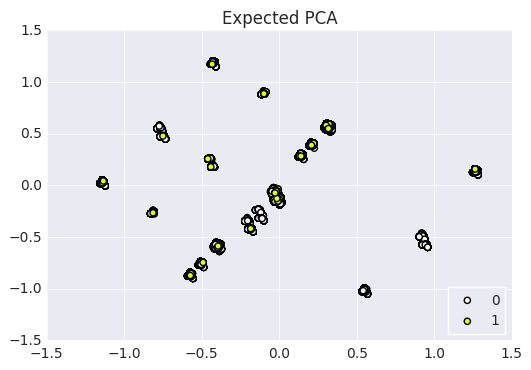

In [16]:
plot_embedding(embedding, Y_test, 2, 'Expected PCA') ## 視覺化, 看起來幾乎不是線性可分的

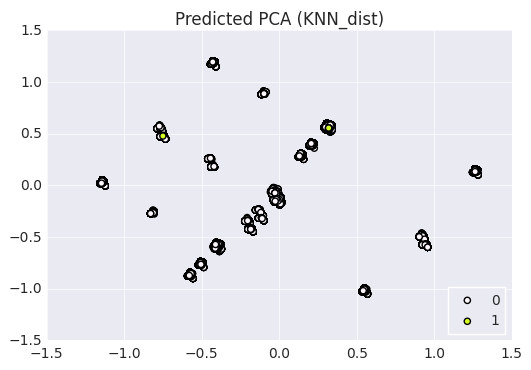

[[96082     3]
 [   58     3]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     96085
          1       0.50      0.05      0.09        61

avg / total       1.00      1.00      1.00     96146

0.089552238806


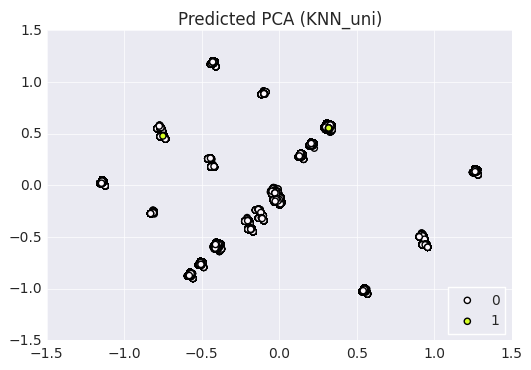

[[96082     3]
 [   58     3]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     96085
          1       0.50      0.05      0.09        61

avg / total       1.00      1.00      1.00     96146

0.089552238806


In [17]:
for model_name, model in classifiers.items(): ## 但也不能高興得太早，recall 看起來應該不會太好
    model.fit(data,label)
    predicted = model.predict(X_test_svd)
    confusion_metrix = skl.metrics.confusion_matrix(Y_test, predicted)
    plot_embedding(embedding, predicted, 2, 'Predicted PCA (%s)'%model_name)
    inclass_precision = skl.metrics.classification_report(Y_test, predicted)
    score = f1_score(Y_test, predicted)
    print(confusion_metrix)   ## 看看每個 model 在未知的資料上表現如何，判斷模型是否 underlearning, 注意，我們只在乎 label==1 的部分
    print(inclass_precision)  ## 同上
    print(score)

看來挺糟糕的 :\

補充從 R script 得到的這份 training data 的 ANOVA 結果（從九十萬筆資料隨機抽樣5000筆資料）：

```R
               Df Sum Sq  Mean Sq   F value Pr(>F)    
adx             1  0.000 0.000003 2.192e+23 <2e-16 ***
spaceType       1  0.000 0.000011 9.356e+23 <2e-16 ***
spaceId       128  0.516 0.004034 3.451e+26 <2e-16 ***
ip           4839  3.480 0.000719 6.154e+25 <2e-16 ***
os              3  0.000 0.000000 2.000e-03 0.9999    
campaignId      1  0.000 0.000000 3.089e+00 0.0911 .  
advertiserId    1  0.000 0.000000 1.496e+00 0.2327    
Residuals      25  0.000 0.000000                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
```

可以看出 adx, spaceType, spaceId, ip 對 click 的影響似乎是顯著的？

也許可以實驗看看只選擇 adx, spaceType, spaceId, ip 當作 feature？或是使用 PCA 做降維？

因為他們對 click 的影響較顯著？ p<0.05